## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

### Обзор данных

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<div class="alert alert-block alert-warning">В нашем распоряжении 7591 размеченных объекта. Пропусков и неожиданных типов данных не наблюдаем.</div> 

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В выборке 7591 фотографии с маркировкой возраста. Возраста в диапазоне от года до 100 лет.

### Возрастное распределение

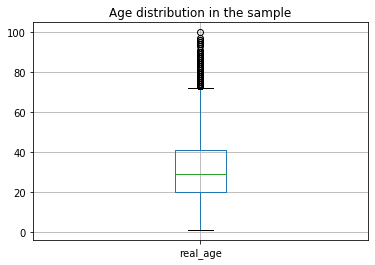

In [ ]:
labels.boxplot('real_age')
plt.title('Age distribution in the sample')
plt.show()

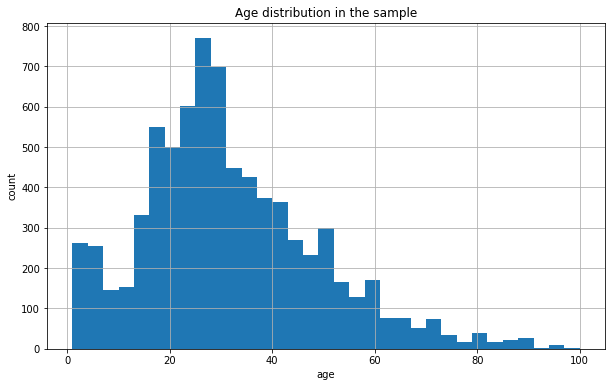

In [ ]:
labels['real_age'].plot(kind='hist', bins=33, grid=True, figsize=(10,6))
plt.title('Age distribution in the sample')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

В том, как распределены возраста людей на фото, ничего необычного не видно. Достаточно мало фотографий детей и пожилых людей, много - людей 18-40 лет. 

### Изображения

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=15,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
images, age = next(datagen_flow)

In [ ]:
images.shape

(15, 256, 256, 3)

Выгрузим 15 изображений:

Имеем 15 цветных изображений размером 256 Х 256 пикселей.

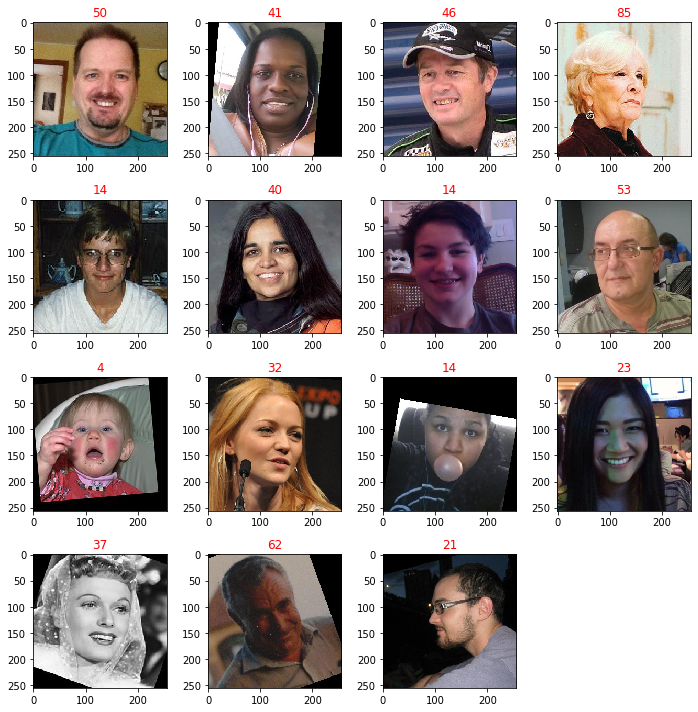

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(age[i], color='red')
    plt.tight_layout()

* На всех изображениях лица. 
* Есть изображение ч/б.
* Несколько изображений искажены (поворот на n градусов).
* Лица в профиль и в анфас.
* На некоторых изображениях есть объекты, закрывающие лицо - пузырь из жвачки, очки, микрофон.

### Вывод

В датасете 7591 цветных фотографий 256 Х 256 пикселей лиц людей в возрасте от года до 100 лет. Некоторые фото искажены или имеют дополнительные объекты, закрывающие часть лица. 

## Обучение

Код из GPU тренажера целиком:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(
        rescale=1/255., 
        validation_split=0.25,
        horizontal_flip=True)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

    
def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    #backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mae'])
    return model


def train_model(model, 
               train_data, 
               test_data, 
               epochs=12,
               steps_per_epoch=None, 
               validation_steps=None, 
               batch_size = None):
  
    train_datagen_flow = train_data
    test_datagen_flow = test_data
    if steps_per_epoch==None:
        steps_per_epoch=len(train_data)
    if validation_steps==None:
        validation_steps=len(test_data)
    model.fit(train_data, 
              validation_data=(test_data), 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch, 
              batch_size=batch_size,
              validation_steps=validation_steps, 
              verbose=2, 
              shuffle=True)
    return model 


## Вывод GPU тренажёра

![title](https://downloader.disk.yandex.ru/preview/ae879cdc5db422857d16726130adf5a9e5f0da0bfcb84cdbd4b5daf7ac07d995/6130d744/oFmGCUSZZnfP25jDzb8rHSBij2k-FQaiVH4RknxMQjeiM5gde8i6LI0S0twbz9dAOodmNCV_uhvex7lalcmMuw%3D%3D?uid=0&filename=vyvod_trenazhera.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048)

Train for 356 steps, validate for 119 steps

Epoch 1/12

2021-09-02 09:05:21.070281: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2021-09-02 09:05:21.386230: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 49s - loss: 217.2346 - mae: 11.0184 - val_loss: 682.0247 - val_mae: 20.8821

Epoch 2/12

356/356 - 39s - loss: 111.0280 - mae: 8.0023 - val_loss: 219.8626 - val_mae: 11.3558

Epoch 3/12

356/356 - 40s - loss: 85.7541 - mae: 7.0858 - val_loss: 113.3138 - val_mae: 7.8561

Epoch 4/12

356/356 - 39s - loss: 74.7288 - mae: 6.5295 - val_loss: 86.7549 - val_mae: 7.0808

Epoch 5/12

356/356 - 39s - loss: 61.5766 - mae: 5.9610 - val_loss: 111.3598 - val_mae: 7.9790

Epoch 6/12

356/356 - 39s - loss: 50.2001 - mae: 5.4407 - val_loss: 127.2942 - val_mae: 8.8198

Epoch 7/12

356/356 - 39s - loss: 46.0137 - mae: 5.2152 - val_loss: 110.9460 - val_mae: 8.2738

Epoch 8/12

356/356 - 39s - loss: 37.8744 - mae: 4.7079 - val_loss: 88.2530 - val_mae: 7.1367

Epoch 9/12

356/356 - 39s - loss: 32.0782 - mae: 4.3620 - val_loss: 72.6386 - val_mae: 6.3713

Epoch 10/12

356/356 - 39s - loss: 30.0282 - mae: 4.1679 - val_loss: 116.2685 - val_mae: 8.3657

Epoch 11/12

356/356 - 39s - loss: 28.0259 - mae: 4.0382 - val_loss: 79.5523 - val_mae: 6.6981

Epoch 12/12

356/356 - 39s - loss: 24.7575 - mae: 3.7995 - val_loss: 78.5064 - val_mae: 6.5629

## Вывод

Построенная на основе ResNet50 и обученная на нашей тренировочной выборке нейросеть за 12 эпох существенно снизила mse на валидации (с 682 до 78.5). Предсказание возраста пока не великолепное, но возрастную категорию уже угадывает хорошо. Вероятно, при дальнейшем обучении ошибка могла стать еще меньше. 

<div class="alert alert-block alert-warning">
Заказчик хотел решить две задачи:
    
<b>Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.</b> В имеющемся виде наша модель уже может принести пользу в решении этой задачи, так как неплохо определяет возрастную группу. Ошибка в 6.5 лет позволит отличить дошкольника, подростка, взрослого и пожилого человека. На основании этого будет возможным подобрать интересующие определенную возрастную группу категории товаров. 
    
<b>Контролировать добросовестность кассиров при продаже алкоголя.</b> В части того вопроса наша модель поможет плохо, так как может не отличить старшего подростка от взрослого. Нам нужна большая точность. Сейчас она поможет избежать только совсем вопиющих случаев продажи алкоголя младшим детям.
</div>